# Delayed AND task

* Dist. input: 0 ó 1 
* % inputs: 99% 
* Dist. Win: [-1; +1]
* in scaling: 0.05 
* Dist. W: rand[0.0,1] 
* SR: 0.99 
* num. trials: 25 

In [1]:
# -*- coding: utf-8 -*-
from __future__ import division, print_function, absolute_import

import numpy as np
import networkx as nx
import pandas as pd
import random

from reservoir_tools.utils import get_spectral_radius, nrmse, bisection, get_args_index, is_number
from reservoir_tools.control_graphs import control_graphs, randomize_network
from reservoir_tools.datasets import narma10, narma30, and__delay
from reservoir_tools.tasks import memory_capacity, critical_memory_capacity
from reservoir_tools.readouts import LinearRegression, RidgeRegression
from reservoir_tools.reservoirs import simulate_reservoir_dynamics, remove_node
from reservoir_tools import grn_networks
from reservoir_tools import network_tools as nt
from reservoir_tools.network_statistics import average_degree, connectivity_fraction
from reservoir_tools.load_preserving_sign import load_preserving_signs

In [7]:
def reservoir_performance_example(data_source, adj_matrix, input_weight=None,
                          spectral_radius_scale=0.9, with_bias=True):

    if hasattr(adj_matrix, "todense"):
        adj_matrix = adj_matrix.todense()
    adj_matrix = np.asarray(adj_matrix)

    # Generate dataset
    [x, y] = data_source.func()
    #print(len(x))

    #weights = adj_matrix * (np.random.random(adj_matrix.shape)*2-1)
    weights = adj_matrix * np.random.uniform(0.0,1,size=adj_matrix.shape)

    if spectral_radius_scale:
        spectral_radius = get_spectral_radius(weights)
        if spectral_radius == 0:
            raise RuntimeError("Nilpotent adjacency matrix matrix")
        weights *= spectral_radius_scale / spectral_radius

    in_scaling = 0.05
    in_weight = input_weight * in_scaling

    res_dynamics = [simulate_reservoir_dynamics(weights.T, in_weight.T,
                                                i_sig)
                    for i_sig in x]
    rregr = RidgeRegression(use_bias=with_bias)
    [rregr.train(x_train, y_train)
     for x_train, y_train in zip(res_dynamics[:-1], y[:-1])]
    pred = rregr(res_dynamics[-1])
    comp = y[-1]
    #comp = (comp[:, None] if comp.ndim == 1
     #               else comp)
    
###### new
    output_target_digitalized = comp>0.5
    pred_digitalized =pred>0.5
    uno = np.array(output_target_digitalized, dtype=int)
    dos = np.ravel(np.array(pred_digitalized, dtype=int))
###### new
    nrmse_res = nrmse(dos, uno)
    print("NRMSE = ",nrmse_res)

    if np.isnan(nrmse_res) or np.isinf(nrmse_res):
        raise RuntimeError("The NRMSE value obtained is not finite.")

    return pred, y[-1], x[-1]


class _data_source():
    def __init__(self, name, func):
        self.name = name
        self.func = func


data_sources = [_data_source("10th order NARMA", narma10),
                _data_source("30th order NARMA", narma30),
                _data_source("anddelayed", and__delay)
                ]

cp_file_layout = "multy_{task}NARMA_{system}_{num_trials}trials.cp"

In [8]:
SR_scale = 0.99
#SR_scale = 1.2
rand_inputs = True
num_trials = 25
count = 0
prngI = np.random.RandomState(42)

G=load_preserving_signs("reservoir_tools/red_simplificada.txt")
graph = nt.prune_graph(G, verbose=1)

k = graph
        
size = k.number_of_nodes() # 70
#size=600
num_inputs = float('0.66')
if num_inputs < 1:  # it cannot be the number of inputs
    num_inputs *= size  # so it must mean the proportion
num_inputs = int(num_inputs)
inputs_arr = np.sign(np.random.rand(size, 2) - 0.5)
#inputs_arr = 2*np.random.rand(size, 2) - 1.0
inputs_arr[num_inputs:] = 0

a = nx.to_pandas_adjacency(k)
arr = a.to_numpy()
adj_matrix = np.asarray(arr)
#adj_matrix = adj_matrix.T
#print(adj_matrix)
#print(adj_matrix.shape)



if rand_inputs:
    np.random.shuffle(inputs_arr)

pred, output_target, input = reservoir_performance_example(data_sources[2], adj_matrix,
                            input_weight=inputs_arr,
                            spectral_radius_scale=SR_scale)

Deleted nodes: 3064 (23 roots, 3041 leaves)
Deleted nodes: 95 (2 roots, 93 leaves)
Deleted nodes: 14 (0 roots, 14 leaves)
Deleted nodes: 2 (0 roots, 2 leaves)
Deleted nodes: 1 (0 roots, 1 leaves)
NRMSE =  0.0


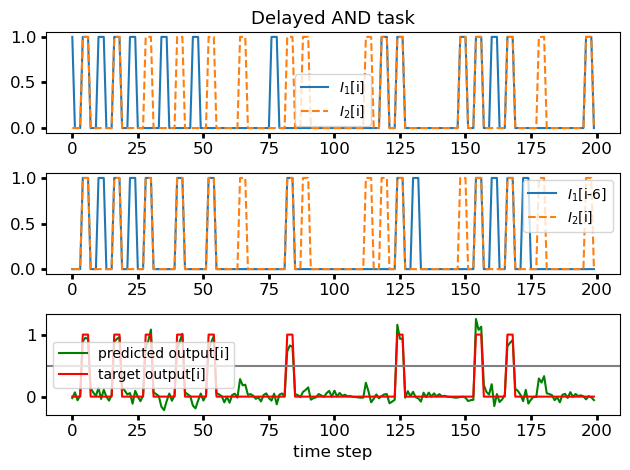

In [4]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(3)
#fig.suptitle('Vertically stacked subplots')
ax1.set_title("Delayed AND task", fontsize=13)
ax1.plot(input[(200):(400),0], label = r"$I_1$[i]")
ax1.plot(input[200:400,1], "--", label = r"$I_2$[i]")
ax2.plot(input[(200-6):(400-6),0], label = r"$I_1$[i-6]")
ax2.plot(input[200:400,1], "--", label = r"$I_2$[i]")
ax3.plot(pred[200:400], color = "green", label = "predicted output[i]")
ax3.plot(output_target[200:400], color = "red", label = "target output[i]")
ax3.axhline(y=0.5, color = "gray")
#ax1.plot(output[0,:], "--",label = "o")
ax1.legend()
ax2.legend()
ax3.legend()
ax3.set_xlabel('time step', fontsize=12)
ax1.tick_params(width=2, axis='both', which='major', labelsize=12)
ax2.tick_params(width=2, axis='both', which='major', labelsize=12)
ax3.tick_params(width=2, axis='both', which='major', labelsize=12)



#ax1.set_xlim((100,300))
fig.tight_layout()
#plt.savefig('delayedANDexample.pdf',bbox_inches='tight')
plt.show()

# Best small networks

## Memory capacity

In [9]:
error_mean, error_std, nr_incoherent_ffl, nr_neg_feed = np.loadtxt("data/dict3187.txt", delimiter=' ', usecols=(0, 1,2,3), unpack=True,skiprows=1)

In [10]:
import json

with open('data/dict3187.json', 'r') as f:
    dict_nrnodes_list = { int(key) : [item for item in value] for key, value in json.load(f).items()}

In [11]:
cuantas_redes = 0
redes_24_nod_error = []
tamm = []
identificador = []

for key in dict_nrnodes_list.keys():
    for value in dict_nrnodes_list[key]:
        
        if len(value) > 3:
            k = graph.subgraph(value)
            H = k.copy()
            G2 = H.to_undirected()
            Gcc = sorted(nx.connected_components(G2), key=len, reverse=True)
            k2 = k.subgraph(Gcc[0])
            if k2.number_of_nodes() == k.number_of_nodes():
                redes_24_nod_error.append(error_mean[cuantas_redes])
                tamm.append(len(value))
                identificador.append(cuantas_redes)
        cuantas_redes =cuantas_redes + 1 

In [12]:
error_filter = []
tam_filter  = []
identificador_filter = []

for i in range(len(tamm)):
    if redes_24_nod_error[i]<16:
        tam_filter.append(tamm[i])
        error_filter.append(redes_24_nod_error[i])
        identificador_filter.append(identificador[i])

In [13]:
indiss = []
for i in range(len(tam_filter)):
    #if error_filter[i]>= 8.0 and error_filter[i]<= 16.0:
    if error_filter[i]>= (np.mean(error_filter)-1.25*np.std(error_filter)) and error_filter[i]<= (np.mean(error_filter)+1.25*np.std(error_filter)):
        indiss.append([tam_filter[i], error_filter[i],   identificador_filter[i] ])

tam_const = [i[0] for i in indiss]
error_const = [i[1] for i in indiss]
identificador_filter_const = [i[2] for i in indiss]

In [14]:
best_idx= [ 591,678]

In [15]:
best_error = []
best_tam = []
for i in range(len(tam_const)):
    for ins in best_idx:
        if identificador_filter_const[i] == ins:
            best_error.append(error_const[i])
            best_tam.append(tam_const[i])

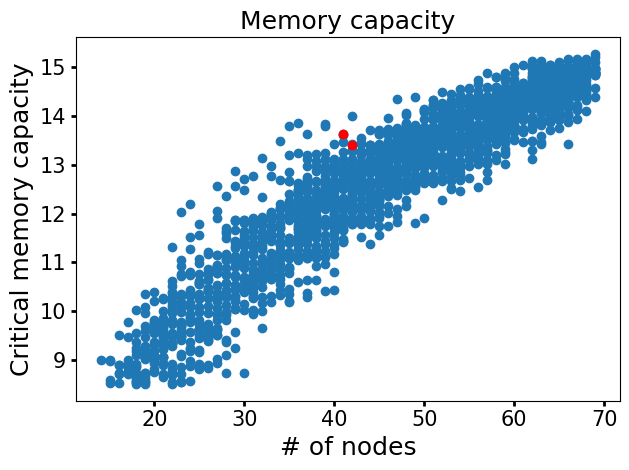

In [16]:
import matplotlib.pyplot as plt 
fig, axes = plt.subplots(figsize = (6.4, 4.8))
plt.scatter(   tam_const , error_const)
plt.xlabel( '# of nodes', size=18)
plt.ylabel("Critical memory capacity", size=18)
plt.title("Memory capacity", fontsize=18)
plt.scatter(best_tam,  best_error, color = "red")
plt.tick_params(width=2, axis='both', which='major', labelsize=15)
plt.tight_layout()
#plt.savefig('best_MEM.pdf',bbox_inches='tight')
plt.show()

## NARMA 10

In [18]:
error_mean, error_std = np.loadtxt("data/TRUE_dict3187NARMA10.txt", delimiter=' ', usecols=(0, 1), unpack=True,skiprows=1)

In [19]:
cuantas_redes = 0
redes_24_nod_error = []
tamm = []
identificador = []

for key in dict_nrnodes_list.keys():
    for value in dict_nrnodes_list[key]:
        
        if len(value) > 3:
            k = graph.subgraph(value)
            H = k.copy()
            G2 = H.to_undirected()
            Gcc = sorted(nx.connected_components(G2), key=len, reverse=True)
            k2 = k.subgraph(Gcc[0])
            if k2.number_of_nodes() == k.number_of_nodes():
                redes_24_nod_error.append(error_mean[cuantas_redes])
                tamm.append(len(value))
                identificador.append(cuantas_redes)
        cuantas_redes =cuantas_redes + 1 

In [20]:
error_filter = []
tam_filter  = []
identificador_filter = []

for i in range(len(tamm)):
    if redes_24_nod_error[i]<1:
        tam_filter.append(tamm[i])
        error_filter.append(redes_24_nod_error[i])
        identificador_filter.append(identificador[i])
       
       

In [21]:
indiss = []
for i in range(len(tam_filter)):
    if error_filter[i]>= (np.mean(error_filter)-1.25*np.std(error_filter)) and error_filter[i]<= (np.mean(error_filter)+1.25*np.std(error_filter)):
        indiss.append([tam_filter[i], error_filter[i],  identificador_filter[i] ])

tam_const = [i[0] for i in indiss]
error_const = [i[1] for i in indiss]
identificador_filter_const = [i[2] for i in indiss]

In [22]:
best_idx= [ 591,678]

In [23]:
best_error = []
best_tam = []
for i in range(len(tam_const)):
    for ins in best_idx:
        if identificador_filter_const[i] == ins:
            best_error.append(error_const[i])
            best_tam.append(tam_const[i])

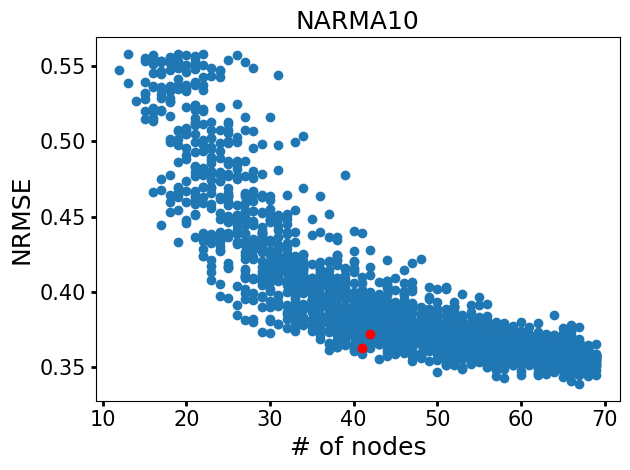

In [24]:
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(figsize = (6.4, 4.8))

plt.scatter(   tam_const , error_const)
plt.xlabel( '# of nodes', size=18)
plt.ylabel("NRMSE", size=18)
plt.title("NARMA10", fontsize=18)
plt.scatter(best_tam,  best_error, color = "red")
plt.tick_params(width=2, axis='both', which='major', labelsize=15)
plt.tight_layout()
#plt.savefig('best_NARMA.pdf',bbox_inches='tight')
plt.show()

## Delayed AND

In [25]:
error_mean, error_std = np.loadtxt("data/TRUE_dict3187and_DELAYED_input_discrete_66input_TRUE.txt", delimiter=' ', usecols=(0, 1), unpack=True)

In [26]:
cuantas_redes = 0
redes_24_nod_error = []
tamm = []
identificador = []

for key in dict_nrnodes_list.keys():
    for value in dict_nrnodes_list[key]:
        
        if len(value) > 3:
            k = graph.subgraph(value)
            H = k.copy()
            G2 = H.to_undirected()
            Gcc = sorted(nx.connected_components(G2), key=len, reverse=True)
            k2 = k.subgraph(Gcc[0])
            if k2.number_of_nodes() == k.number_of_nodes():
                redes_24_nod_error.append(error_mean[cuantas_redes])
                tamm.append(len(value))
                identificador.append(cuantas_redes)
        cuantas_redes =cuantas_redes + 1 

In [27]:
error_filter = []
nro_filter = []
expected_filter = []
tam_filter  = []
identificador_filter = []



for i in range(len(tamm)):
    if redes_24_nod_error[i]<1:
        tam_filter.append(tamm[i])
        error_filter.append(redes_24_nod_error[i])
        identificador_filter.append(identificador[i])
        

In [28]:
indiss = []
for i in range(len(tam_filter)):
    #if error_filter[i]>= 0.0 and error_filter[i]<= 0.5:
    if error_filter[i]>= (np.mean(error_filter)-1.25*np.std(error_filter)) and error_filter[i]<= (np.mean(error_filter)+1.25*np.std(error_filter)):
        indiss.append([tam_filter[i], error_filter[i],  identificador_filter[i] ])

tam_const = [i[0] for i in indiss]
error_const = [i[1] for i in indiss]
identificador_filter_const = [i[2] for i in indiss]

In [29]:
best_idx= [ 591,678]
best_error = []
best_tam = []
for i in range(len(tam_filter)):
    for ins in best_idx:
        if identificador_filter[i] == ins:
            print(ins)
            best_error.append(error_filter[i])
            best_tam.append(tam_filter[i])

591
678


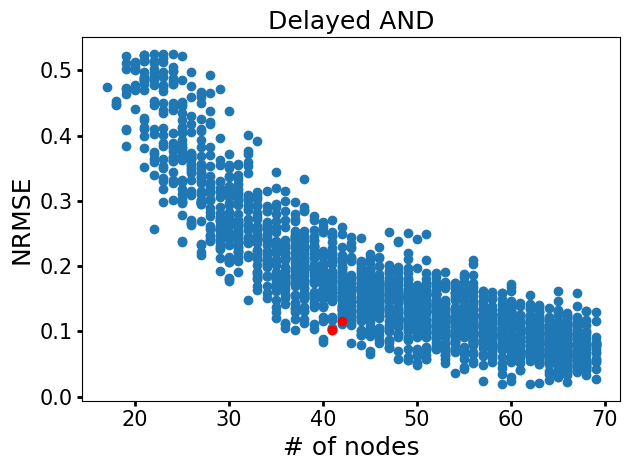

In [30]:
import matplotlib.pyplot as plt 
fig, axes = plt.subplots(figsize = (6.4, 4.8))
plt.scatter(   tam_const , error_const)
plt.xlabel( '# of nodes', size=18)
plt.ylabel("NRMSE", size=18)
plt.title("Delayed AND", fontsize=18)
plt.scatter(best_tam,  best_error, color = "red")
plt.tick_params(width=2, axis='both', which='major', labelsize=15)
plt.tight_layout()
#plt.savefig('best_AND.pdf',bbox_inches='tight')
plt.show()